In [2]:
import numpy as np # le s
from matplotlib import pyplot as plt

In [4]:
CELLShive = 250000
SUPthreshold = 0.2
ELRstochrange = 1 # aps trouve

LIFESPANegg = 3
MORTALITYeggs = 0.03

LIFESPANlarva = 5
MORTALITYlarvae = 0.01

LIFESPANpupa = 12
MORTALITYpupae = 0.001

FACTORothertasks = 0.2
NEEDnurses_per_pupa = 1
NEEDnurses_per_egg = 1

POLLENNEEDadult = 1
POLLENNEEDnurse = 1

FACTORpollenstorage = 6
LOADpollenforager = 1 
TURNSpollenforager = 10
FACTORforagingsuccess = 1
FACTORminpollenforagers = 1
FACTORforagingmax = 1

NECTARNEEDadult = 1
NECTARNEEDnurse = 1
NECTARNEEDactiveforager = 1

LOADpollenforager = 1
TURNSpollenforager = 1

LOADnectarforager = 1
TURNSnectarforager = 1

ProcessorsPerCell = 1
RATIOnectar_to_honey = 1
FACTORothertasks = 1

SyntaxError: invalid syntax (<ipython-input-4-5f1465e3e361>, line 1)

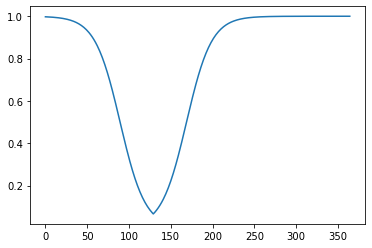

In [3]:
# seasonal factor (page 4, eq 1)
# t en jours
# x le vecteur des parametres x1, x2, ..., x5
def season(t, x = [385, 30, 36, 115, 30]):
    return max(1 - 1 / (1 + x[0] * np.exp(-2 * t / x[1])), 1 / (1 + x[2] * np.exp(-2 * (t - x[3]) / x[4])))

# magie noire, mais ca fait marcher le code
season = np.vectorize(season)

t = np.array(range(0, 365))
plt.plot(season(t))

In [ ]:
# (page 5, eq 2)
def CELLSempty(t):
    return CELLShive - CELLSbrood(t) - STOREpollen(t) - STOREnectar(t) - STOREhoney(t)

# magie on oublie pas
CELLempty = np.vectorize(CELLSempty)

# (page 5, eq 3)
def SUPcomb(t):
    if (CELLSempty(t) / (CELLShive + 1) < SUPthreshold):
        return CELLSempty(t) / (CELLShive + 1) * SUPthreshold
    else:
        return 1.
    
SUPcomb = np.vectorize(SUPcomb)

# (page 5, eq 4)
def ELRstoch(t):
    return np.random.uniform(-ELRstochrange, ELRstochrange)

ELRstoch = np.vectorize(ELRstoch)

# (page 5, eq 5)
def ELR(t):
    return ELRbase * (1 + ELRstoch(t)) * (1 - season(t)) * SUPcomb(t)

ELR = np.vectorize(ELR)

# (page 5, eq 6)
def EGGS(i, t):
    if i == 1:
        return ELR(t - 1) * (1 - MORTALITYeggs)
    else:
        return EGGS(i - 1, t - 1) * (1 - MORTALITYeggs)
    
# devine quoi ? je sais toujours pas ce que ca fait
EGGS = np.vectorize(EGGS)

# (page 5, eq 7)
def CELLSeggs(t):
    return np.sum([EGGS(i, t) for i in range(1, LIFESPANegg)])

CELLSeggs = np.vectorize(CELLSeggs)

In [ ]:
# (page 6, eq 9)
def SURVIVALlarvae(i, t):
    return (1 - CANNIBALISMlarvae(i, t)) * (1 - MORTALITYlarvae)

SURVIVALlarvae = np.vectorize(SURVIVALlarvae)

# (page 6, eq 10)
def CANNIBALISMlarvae(i, t):
    return CANNIBALISMhungerbase(i) * (1 - (INDEXpollensituation(t - 1) * INDEXnursingquality(t - 1)))

CANNIBALISMlarvae = np.vectorize(CANNIBALISMlarvae)

# (page 6, eq 11)
def LARVAE(i, t):
    if i == 1:
        return EGGS(LIFESPANegg, t - 1) * SURVIVALlarvae(1, t)
    else:
        return LARVAE(i - 1, t - 1) * SURVIVALlarvae(i, t)
    
LARVAE = np.vectorize(LARVAE)
    
# (page 6, eq 12)
def CELLSlarvae(t):
    return np.sum([LARVAE(i, t) for i in range(1, LIFESPANlarva)])

CELLSlarvae = np.vectorize(CELLSlarvae)


# (page 6, eq 14)
def PUPAE(i, t):
    if i == 1:
        return LARVAE(LIFESPANlarva, t - 1) * (1 - MORTALITYpupae)
    else:
        return PUPAE(i - 1, t - 1) * (1 - MORTALITYpupae)
    
PUPAE = np.vectorize(PUPAE)

# (page 6, eq 15)
def CELLSpupae(t):
    return np.sum([PUPAE(i, t) for i in range(1, LIFESPANpupa)])

CELLSpupae = np.vectorize(CELLSpupae)

# l'eq 16 elle est moche et en plus 15 marche tres bien.
# jla touche pas moi

# (page 6, eq 17)
def CELLSbrood(t):
    return CELLSeggs(t) + CELLSlarvae(t) + CELLSpupae(t)

CELLSbrood = np.vectorize(CELLSbrood)

In [ ]:
# (page 7, eq 18)
def MORTALITYadult(t):
    tmp = BEESadult(t - 1) + 1
    a = MORTALITYnursing * NURSES(t - 1) / tmp
    b = MORTALITYprocessing * PROCESSORS(t - 1) / tmp
    c = MORTALITYforaging * FORAGERSactive(t - 1) / tmp
    return MORTALITYnursing + a + b + c

MORTALITYadult = np.vectorize(MORTALITYadult)

# page 7, eq 19
# ATTENTION AVEC LA VECTORISATION ICI
# BUG POTENTIEL avec le "t - 1"
def BEESadult(t):
    final_a = []
    for tt in t:
        # cette fonction nique la vectorisation, c'est dommage...
        def tmp_fct(ttt):
            if ttt == 0:
                return t.append(0) # ??? ATTENTION
            return (BEESadult(ttt - 1) + PUPAE(LIFESPANpupa, ttt - 1)) * (1 - MORTALITYadult(ttt))
        
        final_a.append(tt)
        
    return np.array(final_a)

BEESadult = np.vectorize(BEESadult)

# page 7, eq 20
def INDEXrain(t):
    return 1 - RAIN(t)

INDEXrain = np.vectorize(INDEXrain)

# page 7, eq 21
def RAIN(t):
    return HOURSraining_during_daylight(t) / HOURSdaylight(t)

RAIN = np.vectorize(RAIN)

# page 7, eq 22
def INDEXtemperature(t):
    temp = TEMP(t)
    if temp > 14 and temp <= 22:
        return (temp - 14) / 8
    if temp > 22 and temp <= 32:
        return 1
    if temp > 32 and temp <= 40:
        return (40 - temp) / 8
    else:
        return 0

INDEXtemperature = np.vectorize(INDEXtemperature)

# page 7, eq 23
def INDEXflight(t):
    return INDEXrain(t) * INDEXtemperature(t)

In [ ]:
# page 8, eq 24
def INDEXnectaroutside(t):
    return min((1 - season(t)) * 1.5, 1)

INDEXnectaroutside = np.vectorize(INDEXnectaroutside)
INDEXpollenoutside = INDEXnectaroutside

# page 8, eq 26
def NEEDworkers(t):
    return NEEDnurses(t) + NEEDpollenforagers(t)

NEEDworkers = np.vectorize(NEEDworkers)

# page 8, eq 27
def RATIOworkforce(t):
    return min(BEESadult(t) * (1 - FACTORothertasks) / (NEEDworkers(t) + 1), 1)

RATIOworkforce = np.vectorize(RATIOworkforce)

# page 8, eq 28
def NEEDnurses(t):
    return np.sum([LARVAE(i, t) * NEEDnurses_per_lava(i) for i in range(1, LIFESPANlarva)]) + CELLSeggs(t) * NEEDnurses_per_egg + CELLSpupae(t) * NEEDnurses_per_pupa

NEEDnurses = np.vectorize(NEEDnurses)

# page 8, eq 29
def NURSES(t):
    return NEEDnurses(t) * RATIOworkforce(t)

NURSES = np.vectorize(NURSES)

# page 8, eq 30
def INDEXnursingquality(t):
    return NURSES(t) / (NEEDnurses(t) + 1)

INDEXnursingquality = np.vectorize(INDEXnursingquality)

In [ ]:
# page 9, eq 31
def FORAGERS(t):
    return FORAGERSpollen(t) + FORAGERSnectar(t)

FORAGERS = np.vectorize(FORAGERS)

# page 9, eq 32
def FORAGERSactive(t):
    return FORAGERSpollenactive(t) + FORAGERSnectaractive(t)

FORAGERSactive = np.vectorize(FORAGERSactive)

# page 9, eq 33
def NEEDpollen(t):
    return NEEDpollen_larvae(t) + NEEDpollen_adult(t)

NEEDpollen = np.vectorize(NEEDpollen)

# page 9, eq 34
def NEEDpollen_larvae(t):
    return np.sum()

NEEDpollen_larvae = np.vectorize(NEEDpollen_larvae)

# page 9, eq 35
def NEEDpollen_adult(t):
    return BEESadult(t) * POLLENNEEDadult + NURSES(t) * POLLENNEEDnurse

NEEDpollen_adult = np.vectorize(NEEDpollen_adult)

# page 9, eq 36
def NEEDpollenincome(t):
    tmp = np.sum([NEEDpollen(t - d) for d in range(0, 2)]) / 3 * FACTORpollenstorage - STORESpollen(t)
    return max(tmp, 0)

NEEDpollenincome = np.vectorize(NEEDpollenincome)

# page 9, 37
def NEEDpollenforagers(t):
    return NEEDpollenincome(t - 1) / (LOADpollenforager * TURNSpollenforager * FACTORforagingsuccess)

NEEDpollenforagers = np.vectorize(NEEDpollenforagers)


In [ ]:
# page 10, eq 38
def FORAGERSpollen(t):
    a = NEEDpollenforagers(t) * RATIOworkforce(t)
    b = (BEESadult(t) - NURSES(t)) * FACTORminpollenforagers
    c = BEESadult(t) * FACTORforagingmax
    return min(max(a, b), c)

FORAGERSpollen = np.vectorize(FORAGERSpollen)

# page 10, eq 39
def FORAGERSpollenactive(t):
    return FORAGERpollen(t) * INDEXflight(t) * INDEXpollenoutside(t)

FORAGERSpollenactive = np.vectorize(FORAGERSpollenactive)

# page 10, eq 40
def NEEDnectar(t):
    return NEEDnectar_larvae(t) + NEEDnectar_adult(t)

NEEDnectar = np.vectorize(NEEDnectar)

# page 10, eq 41
def NEEDnectar_larvae(t):
    return np.sum([NECTARNEEDlarva(i) * LARVAE(i, t) for i in range(1, LIFESPANlarva)])

NEEDnectar_larvae = np.vectorize(NEEDnectar_larvae)

# page 10, eq 42
def NEEDnectar_adult(t):
    return BEESadult(t) * NECTARNEEDadult + NURSES(t) * NECTARNEEDnurse + FORAGERSactive(t) * NECTARNEEDactiveforager

NEEDnectar_adult = np.vectorize(NEEDnectar_adult)

# page 10, eq 43
def WORKFORCEnectar(t):
    if RATIOworkforce(t) == 1:
        return (BEESadult(t) * (1 - FACTORothertasks)) - NURSES(t) - FORAGERSpollen(t)
    else:
        return 0
 
WORKFORCEnectar = np.vectorize(WORKFORCEnectar)
   
# page 10, eq 44
def FORAGERSnectar(t):
    a = (BEESadult(t) * FACTORforagingmax) - FORAGERSpollen(t)
    b = WORKFORCEnectar(t) - PROCESSORS(t)
    
    return min(a, b)

FORAGERSnectar = np.vectorize(FORAGERSnectar)

# page 10, eq 45
def FORAGERSnectaractive(t):
    return FORAGERSnectar(t) * INDEXflight(t) * INDEXnectaroutside(t)

FORAGERSnectaractive = np.vectorize(FORAGERSnectaractive)


In [ ]:
# page 11, eq 46
def INCOMEpollent(t):
    return FORAGERSpollenactive(t) * LOADpollenforager * TURNSpollenforager * FACTORforagingstoch(t) * FACTORforagingsuccess

INCOMEpollent = np.vectorize(INCOMEpollent)

# page 11, eq 47
def FACTORforagingstoch(t):
    if STOCHASTIC_FACTOR:
        return np.random.uniform(0.75, 1.25)
    else:
        return 1
    
FACTORforagingstoch = np.vectorize(FACTORforagingstoch)

# page 11, eq 48
def INDEXpollensituation(t):
    return min(1, STORESpollen(t) / (NEEDpollen(t) * FACTORpollenstorage + 1))

INDEXpollensituation = np.vectorize(INDEXpollensituation)

# page 11, eq 49
def INCOMEnectar(t):
    a = FORAGERSnectaractive(t) * LOADnectarforager * TURNSnectarforager * FACTORforagingstoch(t) * FACTORforagingsuccess
    b = CELLSempty(t - 1)
    return min(a, b)

INCOMEnectar = np.vectorize(INCOMEnectar)

# page 11, eq 50
def NEEDprocessors(t):
    return STORESnectar(t - 1) * ProcessorsPerCell

NEEDprocessors = np.vectorize(NEEDprocessors)

# page 11, eq 51
def PROCESSORS(t):
    return min(NEEDprocessors(t), WORKFORCEnectar(t))

PROCESSORS = np.vectorize(PROCESSORS)

# page 11, eq 52
def PROCESSEDnectar(t):
    return min(STORESnectar(t - 1) - USAGEnectar(t), PROCESSORS(t) / ProcessorsPerCell)

PROCESSEDnectar = np.vectorize(PROCESSEDnectar)

In [ ]:
# page 12, eq 53
def USAGEpollen(t):
    a = STORESpollen(t - 1)
    b = NEEDpollen(t - 1) * (1 - (FACTORpollensavingmax * (1 - INDEXpollensituation(t - 1))))
    return min(a, b)

USAGEpollen = np.vectorize(USAGEpollen)

# page 12, eq 54
def STORESpollen(t):
    return STORESpollen(t - 1) + INCOMEpollen(t) - USAGEpollen(t)

STORESpollen = np.vectorize(STORESpollen)

# page 12, eq 55
def USAGEnectar(t):
    return min(STORESnectar(t - 1), NEEDnectar(t))

USAGEnectar = np.vectorize(USAGEnectar)

# page 12, eq 56
def USAGEhoney(t):
    return min(STOREShoney(t - 1), (NEEDnectar(t) - USAGEnectar(t)) * RATIOnectar_to_honey)

USAGEhoney = np.vectorize(USAGEhoney)

# page 12, eq 57
def STORESnectar(t):
    return STORESnectar(t - 1) + INCOMEnectar(t) - USAGEnectar(t) - PROCESSEDnectar(t)

STORESnectar = np.vectorize(STORESnectar)

# page 12, eq 58
def STOREShoney(t):
    return STOREShoney(t - 1) - USAGEhoney(t) + (PROCESSEDnectar(t) * RATIOnectar_to_honey)

STOREShoney = np.vectorize(STOREShoney)

# page 12, eq 59
def WEIGHTcolony(t):
    tmp = np.sum([w_larva[i] * LARVAE(i, t) for i in range(1, LIFESPANlarva)])
    return 1/1000 * (w_hivebase + w_cellsbase * CELLShive + w_pollen * STORESpollen(t) + w_nectar * STORESnectar(t) + w_honey * STOREShoney(t) + w_egg * CELLSeggs(t) + w_pupa * CELLSpupae(t) + tmp + w_adult * BEESadult(t))

WEIGHTcolony = np.vectorize(WEIGHTcolony)

# page 13, eq 60
def BEESlazy(t):
    return (BEESadult(t) * (1 - FACTORothertasks)) - FORAGERSactive(t) - NURSES(t) - PROCESSORS(t)

BEESlazy = np.vectorize(BEESlazy)